In [1]:
# pip install ipython

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from IPython.display import Image
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('股票客户流失.xlsx')
df.head()

,账户资金（元）,最后一次交易距今时间（天）,上月交易佣金（元）,累计交易佣金（元）,本券商使用时长（年）,是否流失
0,22686.5,297,149.25,2029.85,0,0
1,190055.0,42,284.75,3889.50,2,0
2,29733.5,233,269.25,2108.15,0,1
3,185667.5,44,211.50,3840.75,3,0
4,33648.5,213,353.50,2151.65,0,1


In [3]:
'''
extract features and labels
'''

X = df.drop(columns='是否流失')
y = df['是否流失']

In [4]:
'''
train_test split
保证测试集样本点够多的情况下，尽量把数据分给训练集
'''

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 若要避免每次程序运行时随机划分,要增加random_state参数
X_train, X_test, y_train, y_test = train_test_split(X, y,\
test_size= 0.2, random_state=1)

In [5]:
'''
fit training data with logistic regression model
'''

lg_model = LogisticRegression()
lg_model.fit(X_train, y_train)

LogisticRegression()

In [6]:
'''
make prediction using fitted model
'''
y_pred = lg_model.predict(X_test)
print(X_test[:5],y_pred[:5])

       账户资金（元）  最后一次交易距今时间（天）  上月交易佣金（元）  累计交易佣金（元）  本券商使用时长（年）
3381  318867.5             20     399.25    5320.75           3
6180  602466.5              2     512.00    8471.85           5
4829   67191.5            133     225.00    2524.35           0
3737   42495.5            188     253.00    2249.95           0
4249   79404.5            116     329.50    2660.05           0 [0 0 0 0 0]


In [7]:
'''
check accuracy of model by using testing data
'''

score = accuracy_score(y_pred, y_test)
lg_model.score(X_test, y_test)

0.7977288857345636

In [8]:
'''
逻辑回归本身预测的是标签分类概率(>=<0.5),
而不是直接分类
这里尝试查看概率
'''

y_pred_proba = lg_model.predict_proba(X_test)
a = pd.DataFrame(y_pred_proba, columns=['不流失概率', '流失概率'])
a['预测值'] = list(y_pred)
a['实际值'] = list(y_test)
a.head()

,不流失概率,流失概率,预测值,实际值
0,0.820415,0.179585,0,0
1,0.840296,0.159704,0,0
2,0.798193,0.201807,0,0
3,0.629892,0.370108,0,1
4,0.616366,0.383634,0,0


In [9]:
'''
Suppose number of features is m in this example, then
预测y=1(流失)的概率为 P:= 1/[1+exp(-(b0 + b1*x1 + b2*x2 +...+ bm*xm))]
这里用代码找出 parameters b0,b1,b2,...,bm
'''

print(lg_model.coef_)  # 系数 bi
print(lg_model.intercept_)  # 截距项 b0

[[ 2.41952469e-05  8.16881491e-03  1.04320950e-02 -2.54894468e-03
  -1.10120609e-04]]
[-1.43393291e-06]


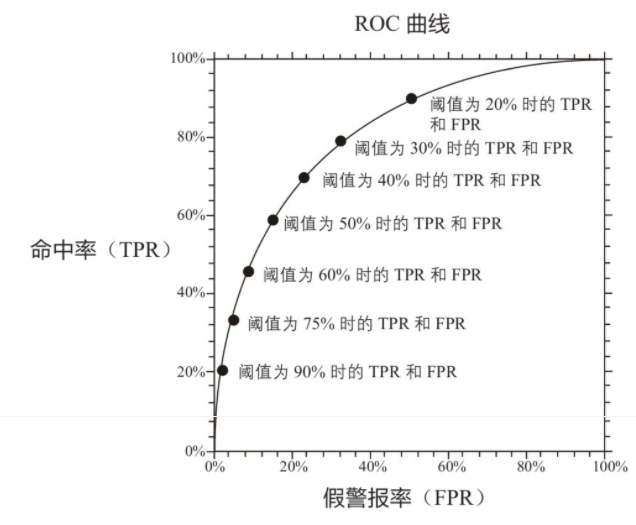

In [10]:
'''
之前的 accuracy score = 预测正确的个数 / 总个数

accuracy score有个缺点: 
无法消除'测试集'('训练集'中应该可以用over/under sampling)中 *样本倾斜* 影响,
*** 即对于majority labels预测能力很好但对于minority labels预测能力很差
--- accuracy score却得益于majority >> minority而很高,产生误导. ***

比如对于(97% 0; 3% 1)的测试集，模型(print('0'))的准确率高达97%,
但事实却是该模型对流失标签1(稀少标签)的预测能力很差.

所以对于2分类模型优劣的主要评估方法有两种:
1. ROC curve
2. KS curve

Given
#{real, prediction} form, and '1' as minority label(如流失), we have:
#{1,1}:             True Positive(TP)正确肯定
#{1,0}:             False Negative(FN)漏报      TP+FN = #'1'
#{0,1}:             False Positive(FP)错报
#{0,0}:             True Negative(TN)正确否定    FP+TN = #'0'

TPR = TP/(TP+FN)   True Positive Rate(TPR)命中率
                   即 稀少样本被正确预测的数量 / 稀少样本总量
                   *** 命中率(稀少样本的正确预测率)TPR越高模型越优秀 ***
                   
FPR = FP/(FP+TN)   False Positive Rate(FPR)假警率
                   即 多数类样本被错误预测的数量 / 多数类样本总量
                   *** 假警率(多数类样本的错误预测率)FPR越低模型越优秀 ***
                   
TPR常与FPR呈现正相关: 例如认为流失概率超过90%才认定为流失,
                     那么会导致假警率很低，但是命中率也很低;
                     而如果调低阈值,
                     例如认为流失概率超过10%就认定为流失,
                     那么命中率就会很高，但是假警率也会很高。
                     
ROC曲线(如图): 越向左上角弯曲越好.
'''

Image(filename = "ROC.png", width = 700, height = 700)

In [11]:
'''
命中率TPR计算

precision: TP/(TP+FP) 即预测为流失(1)中实际流失(1)的比例
RECALL:    即命中率TPR
f1-score:  2TP/(2TP+FP+FN) 即混合度量,对非平衡类别比较有效
support:   样本数

accuracy:  即前面的accuracy score
'''

print(classification_report(y_test, y_pred))  # 传入预测值和实际值

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1061
           1       0.63      0.45      0.52       348

    accuracy                           0.80      1409
   macro avg       0.73      0.68      0.70      1409
weighted avg       0.78      0.80      0.79      1409



In [12]:
'''
继续,ROC曲线比较抽象,我们可以用积分Area Under Curve(AUC值)
来判断模型好坏,面积通常在0.5~1之间,数值越大模型越好,
0.5表示随机判断,1为完美模型,0.8以上的商业模型为佳.
'''

FPR, TPR, thres = roc_curve(y_test, y_pred_proba[:,1])
#第一个参数是测试集实际标签; 第二个参数是logistic regression返回的概率值.

#合并为 dataframe
a = pd.DataFrame()  # 创建一个空DataFrame
a['阈值'] = list(thres)
a['假警报率'] = list(FPR)
a['命中率'] = list(TPR)

a.head() #第一行193%意为直接不可能流失

,阈值,假警报率,命中率
0,1.930369,0.000000,0.000000
1,0.930369,0.000000,0.002874
2,0.867342,0.000000,0.034483
3,0.864187,0.001885,0.034483
4,0.857303,0.001885,0.040230


In [13]:
a.tail() #随着阈值下降,命中与假警率都在上升
#阈值是由测试集中分类为minority label('流失1')的概率自上而下排的.

,阈值,假警报率,命中率
373,0.034940,0.918944,0.994253
374,0.034861,0.918944,0.997126
375,0.032088,0.932139,0.997126
376,0.032016,0.932139,1.000000
377,0.023578,1.000000,1.000000


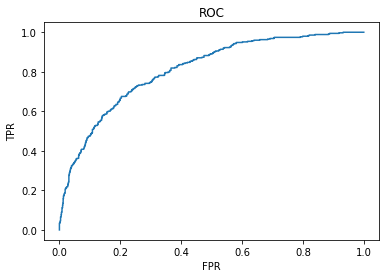

In [14]:
'''
绘制ROC曲线
'''

plt.plot(FPR, TPR)  # 用plot()函数绘制折线图
plt.title('ROC')  # 添加标题
plt.xlabel('FPR')  # 添加x轴标签
plt.ylabel('TPR')  # 添加y轴标签
plt.show()

In [15]:
'''
求曲线下积分AUC值,0.810还不错
'''

auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
print(auc_score)

0.8103854528908967


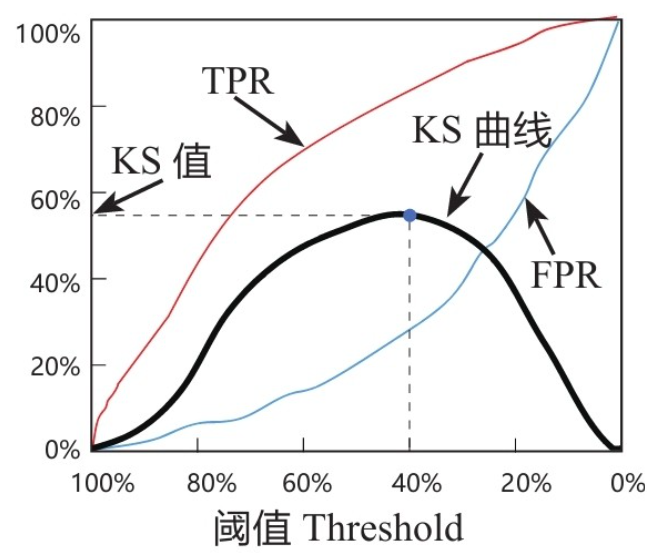

In [16]:
'''
KS曲线和ROC曲线在本质上是相同的，同样关注命中率（TPR）和假警报率（FPR),
希望命中率（TPR）尽可能高，即尽可能揪出潜在流失客户，
同时也希望假警报率（FPR）尽可能低，即不要把未流失客户误判为流失客户。

区别于ROC曲线将假警报率（FPR）作为横坐标，将命中率（TPR）作为纵坐标，
*** KS曲线将阈值作为横坐标，将命中率（TPR）与假警报率（FPR）之差作为纵坐标 ***
如图所示。


·KS值小于0.2，一般认为模型的区分能力较弱；
·KS值在[0.2，0.3]区间内，模型具有一定区分能力；
·KS值在[0.3，0.5]区间内，模型具有较强的区分能力


摘自：《Python大数据分析与机器学习商业案例实战》 — 王宇韬  钱妍竹
'''

Image(filename = "KS.png", width = 700, height = 700)

In [17]:
'''
与KS曲线对应的是KS值
因为希望TPR尽可能大:正确锁定即将流失群体;
FPR尽可能小:尽量避免误判本不会流失的群体
*** KS = max(TPR - FPR) ***
'''

FPR, TPR, thres = roc_curve(y_test, y_pred_proba[:,1]) #与ROC都采用FPR,TPR参数

b = pd.DataFrame()  # 创建一个空DataFrame 
b['阈值'] = list(thres)
b['假警报率'] = list(FPR) 
b['命中率'] = list(TPR)

b.head()

,阈值,假警报率,命中率
0,1.930369,0.000000,0.000000
1,0.930369,0.000000,0.002874
2,0.867342,0.000000,0.034483
3,0.864187,0.001885,0.034483
4,0.857303,0.001885,0.040230


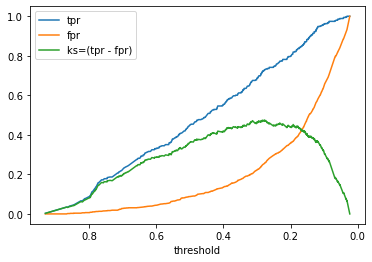

In [18]:
'''
绘制KS曲线
'''
plt.plot(thres[1:], TPR[1:])
plt.plot(thres[1:], FPR[1:])
plt.plot(thres[1:], TPR[1:] - FPR[1:])
plt.xlabel('threshold')
plt.legend(['tpr', 'fpr', 'ks=(tpr - fpr)'])
plt.gca().invert_xaxis()
plt.show()

In [19]:
KS_val = max(TPR - FPR)
print(KS_val)

0.4744656418256471


In [21]:
#或者

b['KS=TPR-FPR'] = b['命中率'] - b['假警报率']
print(max(b['KS=TPR-FPR']))
b[b['KS=TPR-FPR'] == max(b['KS=TPR-FPR'])] #顺便找到对应阈值

0.4744656418256471


,阈值,假警报率,命中率,KS=TPR-FPR
224,0.27769,0.255419,0.729885,0.474466


In [22]:
'''
总结: 

首先是两个重要参数:
TPR: *** 命中率(稀少样本的正确预测率)TPR越高模型越优秀 ***
FPR: *** 假警率(多数类样本的错误预测率)FPR越低模型越优秀 ***

但这两个参数却有正相关性,同增或同减
所以为了求出最佳值希望让模型的 ROC: FPR->TPR曲线尽可能
靠近左上角((TPR,FPR)=(1,0)),
用数学方法来说就是让ROC曲线的积分(面积)AUC尽可能大

同理,用另一种方式来思考,我们也可以让TPR与FPR间的差值尽可能大,
即max(TPR-FPR),
这便是KS办法.
'''

'\n总结: \n\n首先是两个重要参数:\nTPR: *** 命中率(稀少样本的正确预测率)TPR越高模型越优秀 ***\nFPR: *** 假警率(多数类样本的错误预测率)FPR越低模型越优秀 ***\n\n但这两个参数却有正相关性,同增或同减\n所以为了求出最佳值希望让模型的 ROC: FPR->TPR曲线尽可能\n靠近左上角((TPR,FPR)=(1,0)),\n用数学方法来说就是让ROC曲线的积分(面积)AUC尽可能大\n\n同理,用另一种方式来思考,我们也可以让TPR与FPR间的差值尽可能大,\n即max(TPR-FPR),\n这便是KS办法.\n'